In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import stim
print(stim.__version__)

import matplotlib.pyplot as plt
import numpy as np
import math
import re

from ldpc import bp_decoder, bposd_decoder
import time
from src.utils import rank, row_echelon
from src.codes_q import *
from src.codes_q import find_girth, gcd
from src.codes_q import create_QC_GHP_codes, create_cyclic_permuting_matrix, create_generalized_bicycle_codes
from src.build_circuit import build_circuit, dem_to_check_matrices
from src import bpgdg_decoder


1.13.dev1701377008


In [2]:
def decode_phenomenological(N=288, p=0.05, pseudo_prior=None, num_shots=5000, p_arr=None, p_start=0.00001, p_end=0.0001, p_step=0.00001, osd_factor=0.625, use_osd=True, use_gdg=True):
    if N == 288:
        code, A_list, B_list = create_bivariate_bicycle_codes(12, 12, [3], [2,7], [1,2], [3]) # [[288,12,18]]
    elif N == 254:
        code = create_generalized_bicycle_codes(127, [0,15,20,28,66], [0,58,59,100,121]) # [[254,28,14<=d<=20]]
    len_synd = code.hx.shape[0]
    print("p_data", p)
    for p_synd in (p_arr if p_arr is not None else np.arange(p_start, p_end, p_step)):
        print("p_syndrome", p_synd)
        err = np.random.binomial(1, p, (num_shots, code.N)) # [num_shots, N]
        syndrome = (err @ code.hx.T) % 2 # [num_shots, N_half]
        synd_err = np.random.binomial(1, p_synd, (num_shots, len_synd)) # [num_shots, N]
        priors = np.ones(code.N) * p
        synd_priors = np.ones(len_synd) * (p_synd if pseudo_prior is None else pseudo_prior)

        print(f"hx shape {code.hx.shape}")
        new_pcm = np.hstack((code.hx, np.eye(len_synd)))  
        new_prior = np.hstack((priors, synd_priors))
        print(f"new pcm shape {new_pcm.shape}, new prior shape {new_prior.shape}")

        if use_osd:
            osd_num_err = 0
            bpd = bposd_decoder(
                new_pcm, # the parity check matrix
                error_rate=p, # does not matter as channel_prob is set
                channel_probs=new_prior, # assign error_rate to each qubit. This will override "error_rate" input variable
                max_iter=100, # the maximum number of iterations for BP
                bp_method="minimum_sum_log", # messages are not clipped, may have numerical issues
                ms_scaling_factor=osd_factor, # min sum scaling factor. If set to zero the variable scaling factor method is used
                osd_method="osd_cs", # the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
                osd_order=10, # the osd search depth, not specified in [1]
                input_vector_type="syndrome", # "received_vector"
            )
            start_time = time.perf_counter()
            for i in range(num_shots):
                s = (syndrome[i] + synd_err[i]) % 2
                e_hat_osd = bpd.decode(s)
                e_diff = (e_hat_osd[:code.N] + err[i]) % 2
                logical_err = ((e_diff @ code.hz_perp.T) % 2).any()
                osd_num_err += logical_err
            print(f"OSD: num logical error {osd_num_err}/{num_shots}, LER {osd_num_err/num_shots}")
            end_time = time.perf_counter()
            print("Elapsed time:", end_time-start_time)  

        if use_gdg:
            bpgdg = bpgdg_decoder(
                new_pcm,
                channel_probs=new_prior,
                gdg_factor=0.625,
                max_step=40,
                max_tree_depth=4,
                max_side_depth=20,
                max_side_branch_step=30,
                max_tree_branch_step=30,
                multi_thread=True,
                low_error_mode=True,
                # BP preprocessing. instead of using all 2.5 * N/2 columns, only use N columns
                max_iter=8,
                ms_scaling_factor=0.625,
                new_n=None # use first 2*num_row columns after ranking
            )

            gdg_num_err = 0
            num_flag_err = 0
            start_time = time.perf_counter()
            for i in range(num_shots):
                s = (syndrome[i] + synd_err[i]) % 2
                e_hat_gdg = bpgdg.decode(s)  
                num_flag_err += 1 - bpgdg.converge
                e_diff = (e_hat_gdg[:code.N] + err[i]) % 2
                logical_err = ((e_diff @ code.hz_perp.T) % 2).any()
                gdg_num_err += logical_err  

            print("GDG: num flagged error", num_flag_err)
            print(f"GDG: num logical error {gdg_num_err}/{num_shots}, LER {gdg_num_err/num_shots}")
            end_time = time.perf_counter()
            print("Elapsed time:", end_time-start_time)  

# [[288, 12, 18]]

row wt min 6, max 6
col wt min 3, max 3
girth hx 6, hz 6


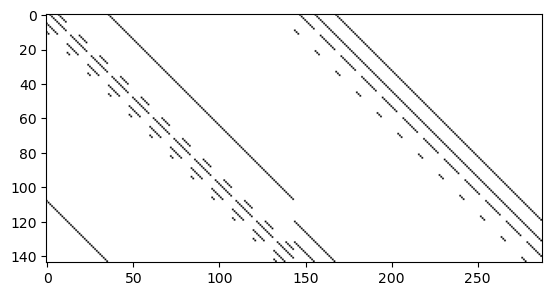

In [6]:
code, _, _ = create_bivariate_bicycle_codes(12, 12, [3], [2,7], [1,2], [3]) # [[288,12,18]]
row_wt = code.hx.sum(axis=1)
col_wt = code.hx.sum(axis=0)
print(f"row wt min {row_wt.min()}, max {row_wt.max()}")
print(f"col wt min {col_wt.min()}, max {col_wt.max()}")
print(f"girth hx {find_girth(code.hx)}, hz {find_girth(code.hz)}") # a bit slow for the 882 code
plt.imshow(code.hx, cmap="gist_yarg")

In [7]:
mat = code.hx
old_rank = rank(mat)
num_row = mat.shape[0]
wt2_codewords = []
for i in range(num_row): # can also use symmetry of the syndrome code, no need to iterate through i
    for j in range(i+1, num_row):
        new_vec = np.zeros((num_row,1))
        new_vec[i] = 1
        new_vec[j] = 1
        new_mat = np.hstack((mat, new_vec))
        if (rank(new_mat) != old_rank + 1):
#             print(f"({i},{j}) in column span")
            wt2_codewords.append((i,j))
print("number of weight two codewords from column span of matrix A is", len(wt2_codewords))

bpgdg = bpgdg_decoder(
    mat,
    channel_probs=np.ones(code.N) * 0.01,
    gdg_factor=0.625,
    max_step=40,
    max_tree_depth=4,
    max_side_depth=20,
    max_side_branch_step=30,
    max_tree_branch_step=30,
    multi_thread=True,
    low_error_mode=True,
    max_iter=8, # can decode more when set to 0, i.e., no reordering
    ms_scaling_factor=0.625,
)

for i,j in wt2_codewords:
    new_vec = np.zeros(144)
    new_vec[i] = 1
    new_vec[j] = 1
    e_hat_gdg = bpgdg.decode(new_vec)
    if bpgdg.converge:
        print(f"GDG succeed in decode syndrome ({i},{j}) with {e_hat_gdg.astype(int).sum()} VNs")


number of weight two codewords from column span of matrix A is 216
GDG succeed in decode syndrome (0,72) with 14 VNs
GDG succeed in decode syndrome (1,73) with 14 VNs


In [8]:
decode_phenomenological(N=288, p=0.03, num_shots=1000000, p_arr=[1e-5,1e-4,1e-3])


p_data 0.03
p_syndrome 1e-05
hx shape (144, 288)
new pcm shape (144, 432), new prior shape (432,)
OSD: num logical error 21/1000000, LER 2.1e-05
Elapsed time: 96.28352196100059
GDG: num flagged error 0
GDG: num logical error 20/1000000, LER 2e-05
Elapsed time: 162.1901877320015
p_syndrome 0.0001
hx shape (144, 288)
new pcm shape (144, 432), new prior shape (432,)
OSD: num logical error 302/1000000, LER 0.000302
Elapsed time: 93.95118816299873
GDG: num flagged error 0
GDG: num logical error 44/1000000, LER 4.4e-05
Elapsed time: 127.54221718899862
p_syndrome 0.001
hx shape (144, 288)
new pcm shape (144, 432), new prior shape (432,)
OSD: num logical error 20164/1000000, LER 0.020164
Elapsed time: 156.8140335850003
GDG: num flagged error 0
GDG: num logical error 1356/1000000, LER 0.001356
Elapsed time: 224.36310438999863


# [[254, 28, 14≤d≤20]]

row wt min 10, max 10
col wt min 5, max 5
girth hx 6, hz 6


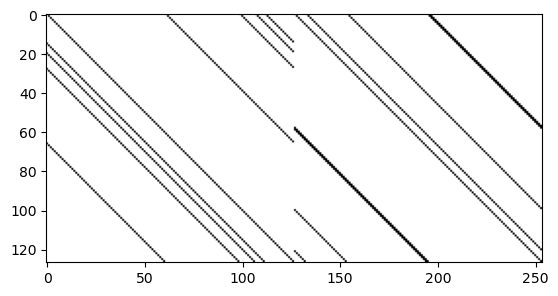

In [9]:
code = create_generalized_bicycle_codes(127, [0,15,20,28,66], [0,58,59,100,121]) # [[254,28,14<=d<=20]]
row_wt = code.hx.sum(axis=1)
col_wt = code.hx.sum(axis=0)
print(f"row wt min {row_wt.min()}, max {row_wt.max()}")
print(f"col wt min {col_wt.min()}, max {col_wt.max()}")
print(f"girth hx {find_girth(code.hx)}, hz {find_girth(code.hz)}") # a bit slow for the 882 code
plt.imshow(code.hx, cmap="gist_yarg")

In [10]:
g1 = [0,1,7]                  # x^7+x+1
g2 = [0,1,3,5,7]              # x^7+x^5+x^3+x+1
print(gcd(g1, [0,127]))       # g1 | x^127-1
print(gcd(g2, [0,127]))       # g2 | x^127-1
print(gcd(g1, [0,3,9,15,21])) # g1(a) | g2(a^3)

decode_phenomenological(N=254, p=0.01, pseudo_prior=1e-6, num_shots=10000000, p_arr=[1e-5,1e-4], use_osd=False)
decode_phenomenological(N=254, p=0.01, pseudo_prior=1e-6, num_shots=10000000, p_arr=[1e-5,1e-4], use_osd=False)


[0, 1, 7]
[0, 1, 3, 5, 7]
[0, 1, 7]
p_data 0.01
p_syndrome 1e-05
hx shape (127, 254)
new pcm shape (127, 381), new prior shape (381,)
GDG: num flagged error 0
GDG: num logical error 0/10000000, LER 0.0
Elapsed time: 298.2580718809986
p_syndrome 0.0001
hx shape (127, 254)
new pcm shape (127, 381), new prior shape (381,)
GDG: num flagged error 1
GDG: num logical error 2/10000000, LER 2e-07
Elapsed time: 299.52171875800195
p_data 0.01
p_syndrome 1e-05
hx shape (127, 254)
new pcm shape (127, 381), new prior shape (381,)
GDG: num flagged error 0
GDG: num logical error 2/10000000, LER 2e-07
Elapsed time: 299.5995068209995
p_syndrome 0.0001
hx shape (127, 254)
new pcm shape (127, 381), new prior shape (381,)
GDG: num flagged error 0
GDG: num logical error 1/10000000, LER 1e-07
Elapsed time: 301.11442290800187
